In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import sys
import os
import random
import pymc3 as pm
import theano.tensor as T
import exoplanet as xo
import pickle
import pandas as pd
import emcee

import caustic as ca

random.seed(42)

mpl.rcParams['axes.labelsize'] = 22
mpl.rcParams['xtick.labelsize'] = 22
mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['axes.titlesize'] = 22

# Print library version numbers
print("Numpy version", np.__version__)
print("PyMC3 version", pm.__version__)

%config InlineBackend.figure_format = 'retina'

Numpy version 1.13.0
PyMC3 version 3.7


# Load traces of all fitted events into memory

In [2]:
def load_samples(data_path, param_name):
    param_samples = []
    logp_param_samples = []
    
    for directory in os.listdir(data_path):
        # Load trace
        path = data_path + directory 
        try:
            trace = pd.read_csv(path + '/PSPL_hmc/trace.csv')
            # Exclude samples if the values are silly
            if not (np.mean(trace[param_name].values) > 2000.):
                param_samples.append(trace[param_name].values)
                logp_param_samples.append(trace['logp_' + param_name].values)
        except:
            pass
        
    return param_samples, logp_param_samples

samples, logp_samples = load_samples('../output/2017/', 'ln_Delta_F__0')

In [3]:
medians = []
medians_logp = []

for s in samples:
    medians.append(np.median(s))
    
for s in logp_samples:
    medians_logp.append(np.median(s))

In [58]:
len(medians) # nr. of OGLE light curves

825

Text(0.5, 0, 'median $\\ln\\,\\Delta F$')

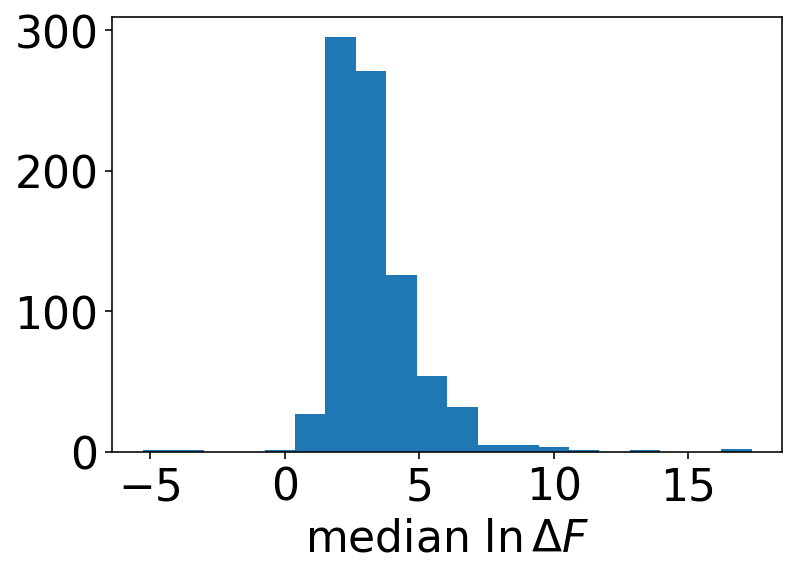

In [57]:
# Plot histograms 

fig, ax = plt.subplots()

ax.hist(medians, bins=20);
ax.set_xlabel('median $\ln\,\Delta F$')

# Fit "ongoing" event in isolation

First, let's load an OGLE light and mask it to pretend we haven't seen data after certain time

In [5]:
event_ogle = ca.data.OGLEData("../../../data/OGLE_ews/2017/blg-0324")

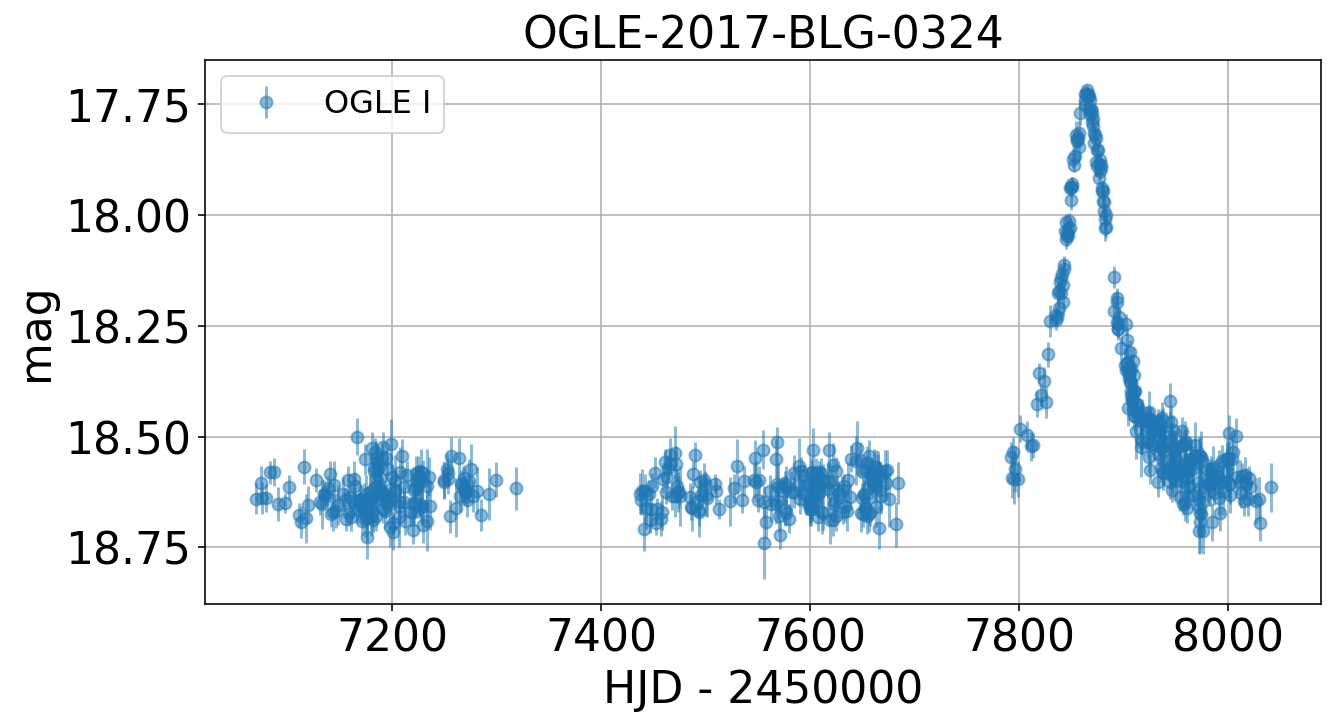

In [6]:
fig, ax = plt.subplots(figsize=(10, 5))
event_ogle.plot(ax)

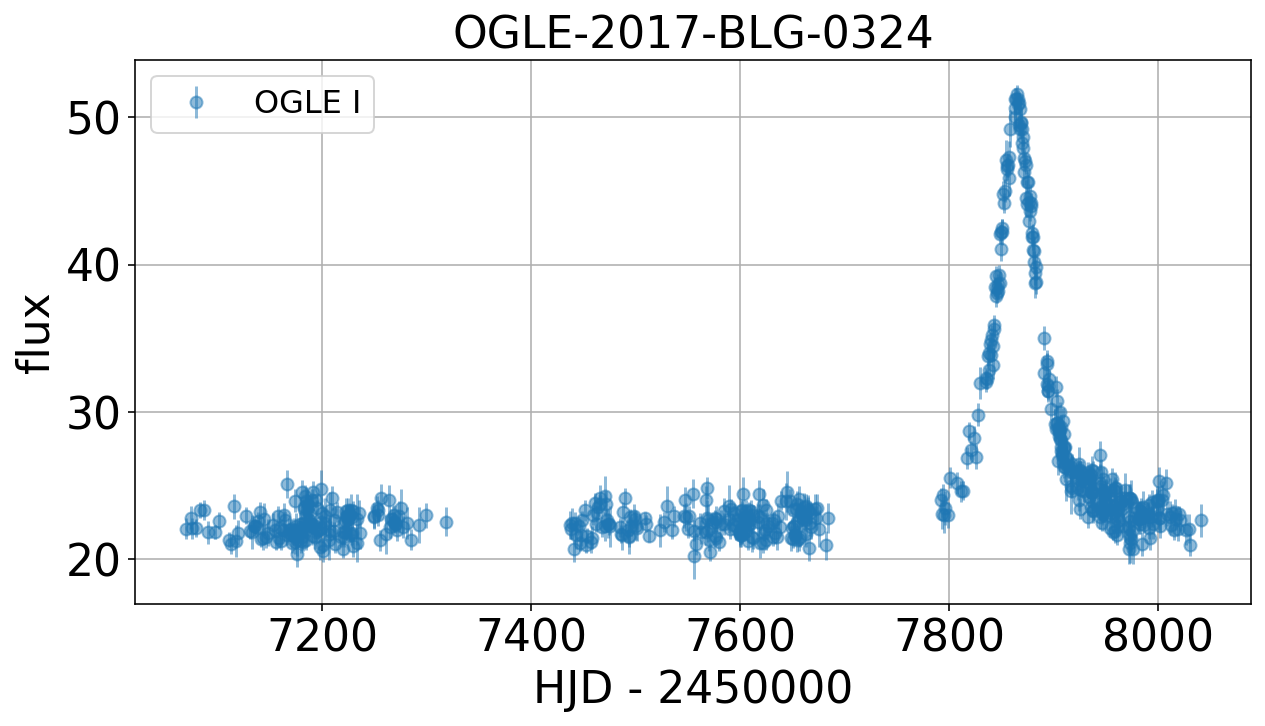

In [7]:
event_ogle.units = 'fluxes'
fig, ax = plt.subplots(figsize=(10, 5))
event_ogle.plot(ax)

In [8]:
# Update mask
mask = event_ogle.light_curves[0]['HJD'] - 2450000 < 7830
event_ogle.light_curves[0]['mask'] = mask

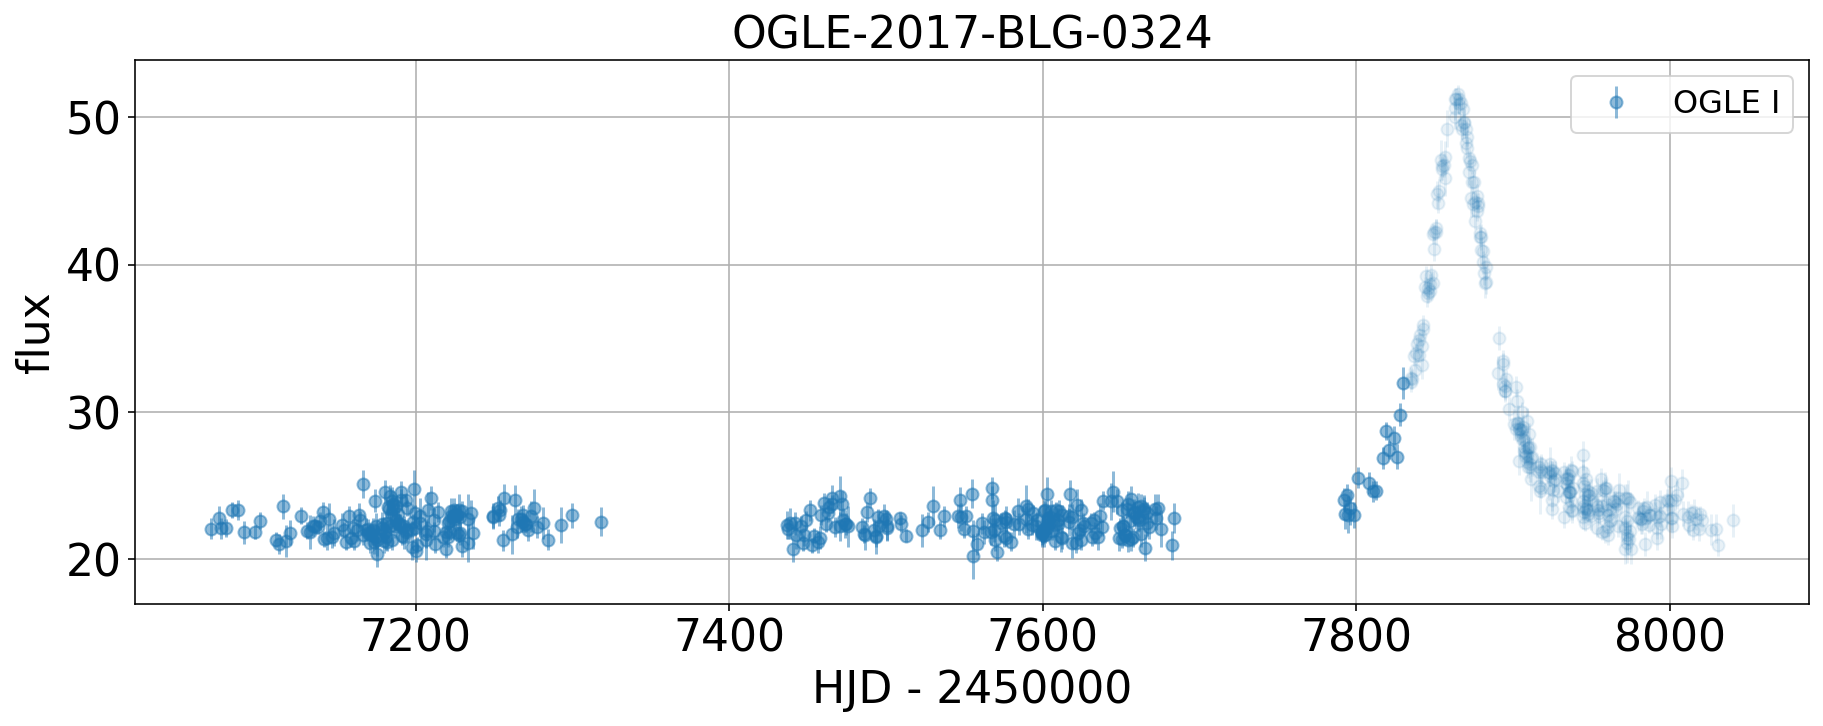

In [9]:
fig, ax = plt.subplots(figsize=(15, 5))
event_ogle.plot(ax)

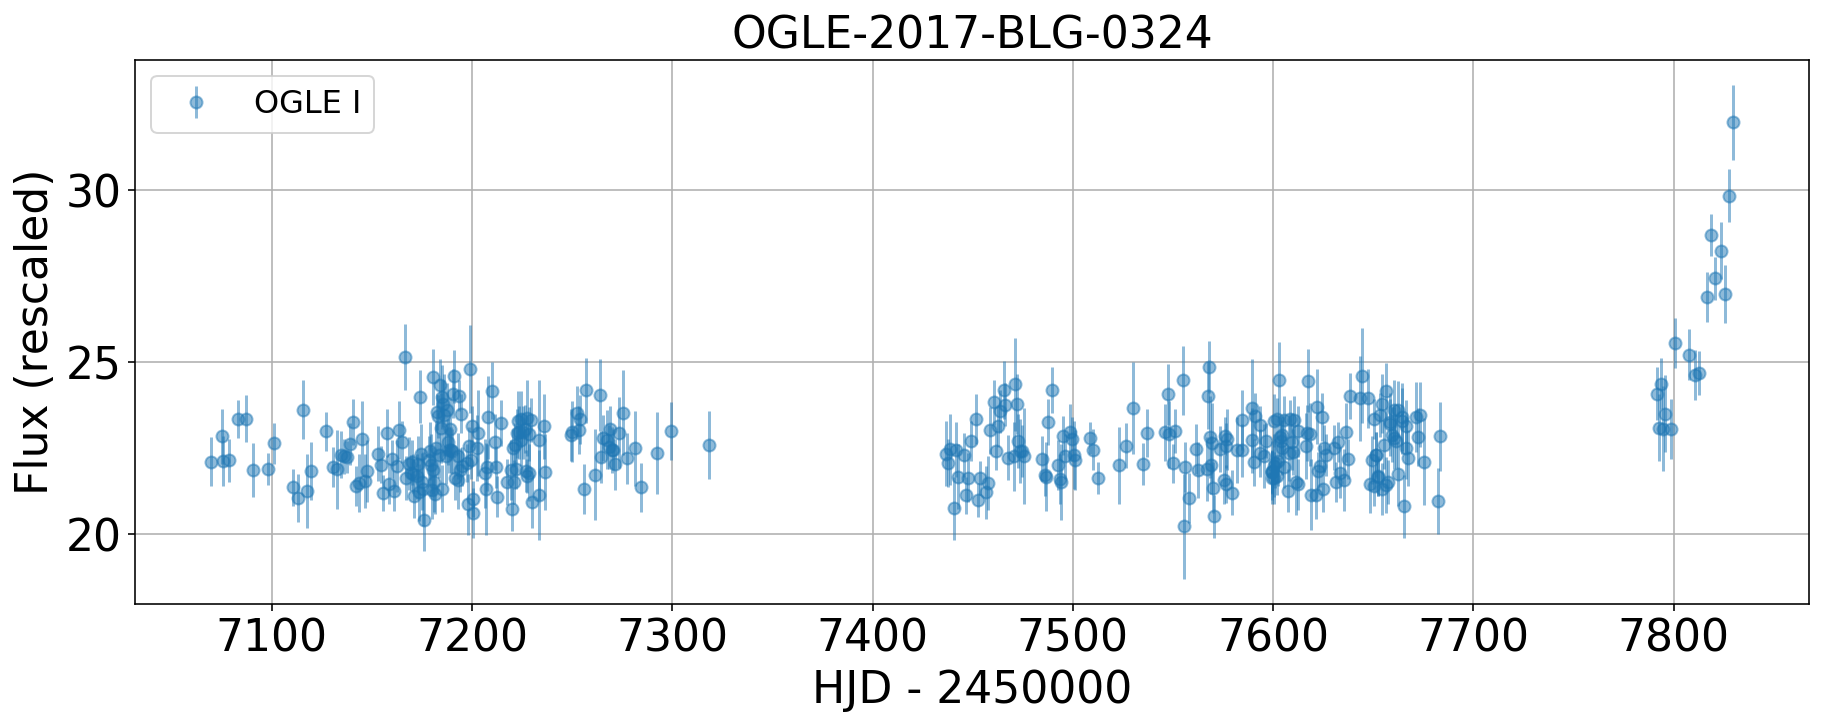

In [10]:
fig, ax = plt.subplots(figsize=(15, 5))
event_ogle.plot_standardized_data(ax, rescale=False)

In [11]:
# Initialize a SingleLensModel object
pspl_model = ca.models.SingleLensModel(event_ogle, standardize=False) 

In [12]:
n_bands = len(event_ogle.light_curves)
BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
BoundedNormal_1 = pm.Bound(pm.Normal, lower=1.) 

with pspl_model:
    # Initialize linear parameters   
    init_ln_Delta_F = np.log(ca.utils.estimate_peak_flux(event_ogle) -\
        ca.utils.estimate_baseline_flux(event_ogle))
    
    ln_Delta_F = pm.Normal('ln_Delta_F', 
        mu=5.*T.ones(n_bands),
        sd=10.*T.ones(n_bands),
        testval=T.as_tensor_variable(init_ln_Delta_F),
        shape=(n_bands))

    F_base = pm.Normal('F_base', 
        mu=T.zeros(n_bands), 
        sd=1e3*T.ones(n_bands),
        testval=T.as_tensor_variable(ca.utils.estimate_baseline_flux(event_ogle)),
        shape=(n_bands))
    
    # Initialize non-linear parameters
    ## Posterior is multi-modal in t0 and it's critical that the it is 
    ## initialized near the true value
    t_mid = (pspl_model.t_max - pspl_model.t_min)/2
    t_range = pspl_model.t_max - pspl_model.t_min
    t_0 = pm.Normal('t_0', t_mid, 2*t_range,
        testval=ca.utils.estimate_t0(event_ogle))
    
    u_0 = BoundedNormal('u_0', mu=0., sd=1.5, testval=0.1)
    
    ln_teff = pm.Normal('ln_t_eff', mu=3., sd=5., testval=4.)
    
    # Deterministic transformations
    t_E = pm.Deterministic("t_E", T.exp(ln_teff)/u_0) 
    m_source, g = ca.utils.compute_source_mag_and_blend_fraction(event_ogle, 
                                pspl_model, T.exp(ln_Delta_F), F_base, u_0)
    pm.Deterministic("m_source", m_source)
    pm.Deterministic("g", g)
    
    # Compute the trajectory of the lens
    trajectory = ca.trajectory.Trajectory(event_ogle, t_0, u_0, t_E)
    u = trajectory.compute_trajectory(pspl_model.t)
        
    # Compute the magnification
    mag = pspl_model.compute_magnification(u, u_0)
    
    # Compute the mean model
    mean = T.exp(ln_Delta_F)*mag + F_base
    
    # We allow for rescaling of the error bars by a constant factor
    c = BoundedNormal_1('c', 
        mu=T.ones(n_bands),
        sd=2.*T.ones(n_bands),
        testval=1.5*T.ones(n_bands),
        shape=(n_bands))

    # Diagonal terms of the covariance matrix
    var_F = (c*pspl_model.sig_F)**2
    
    # Compute the Gaussian log_likelihood, add it as a potential term to the model
    ll = pspl_model.compute_log_likelihood(pspl_model.F - mean, var_F)
    pm.Potential('log_likelihood', ll)

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '12983' (I am process '13869')


In [20]:
with pspl_model:
    # Print initial logps
    initial_logps = [RV.logp(pspl_model.test_point) for RV in pspl_model.basic_RVs]
    print("Initial values of log priors:", initial_logps)
    
    # Run sampling
    trace = pm.sample(tune=1000, draws=2000, cores=4, step=xo.get_dense_nuts_step(target_accept=0.9))

Initial values of log priors: [array(-3.2765490579821925), array(-7.826945655463614), array(-20.24558419321984), array(-3.6292109565291044), array(-2.548376445638773), array(-2.3364828943245635)]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, ln_t_eff, u_0, t_0, F_base, ln_Delta_F]
Sampling 4 chains: 100%|██████████| 12000/12000 [01:15<00:00, 159.61draws/s]
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.820917111367, but should be close to 0.9. Try to increase the number of tuning steps.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


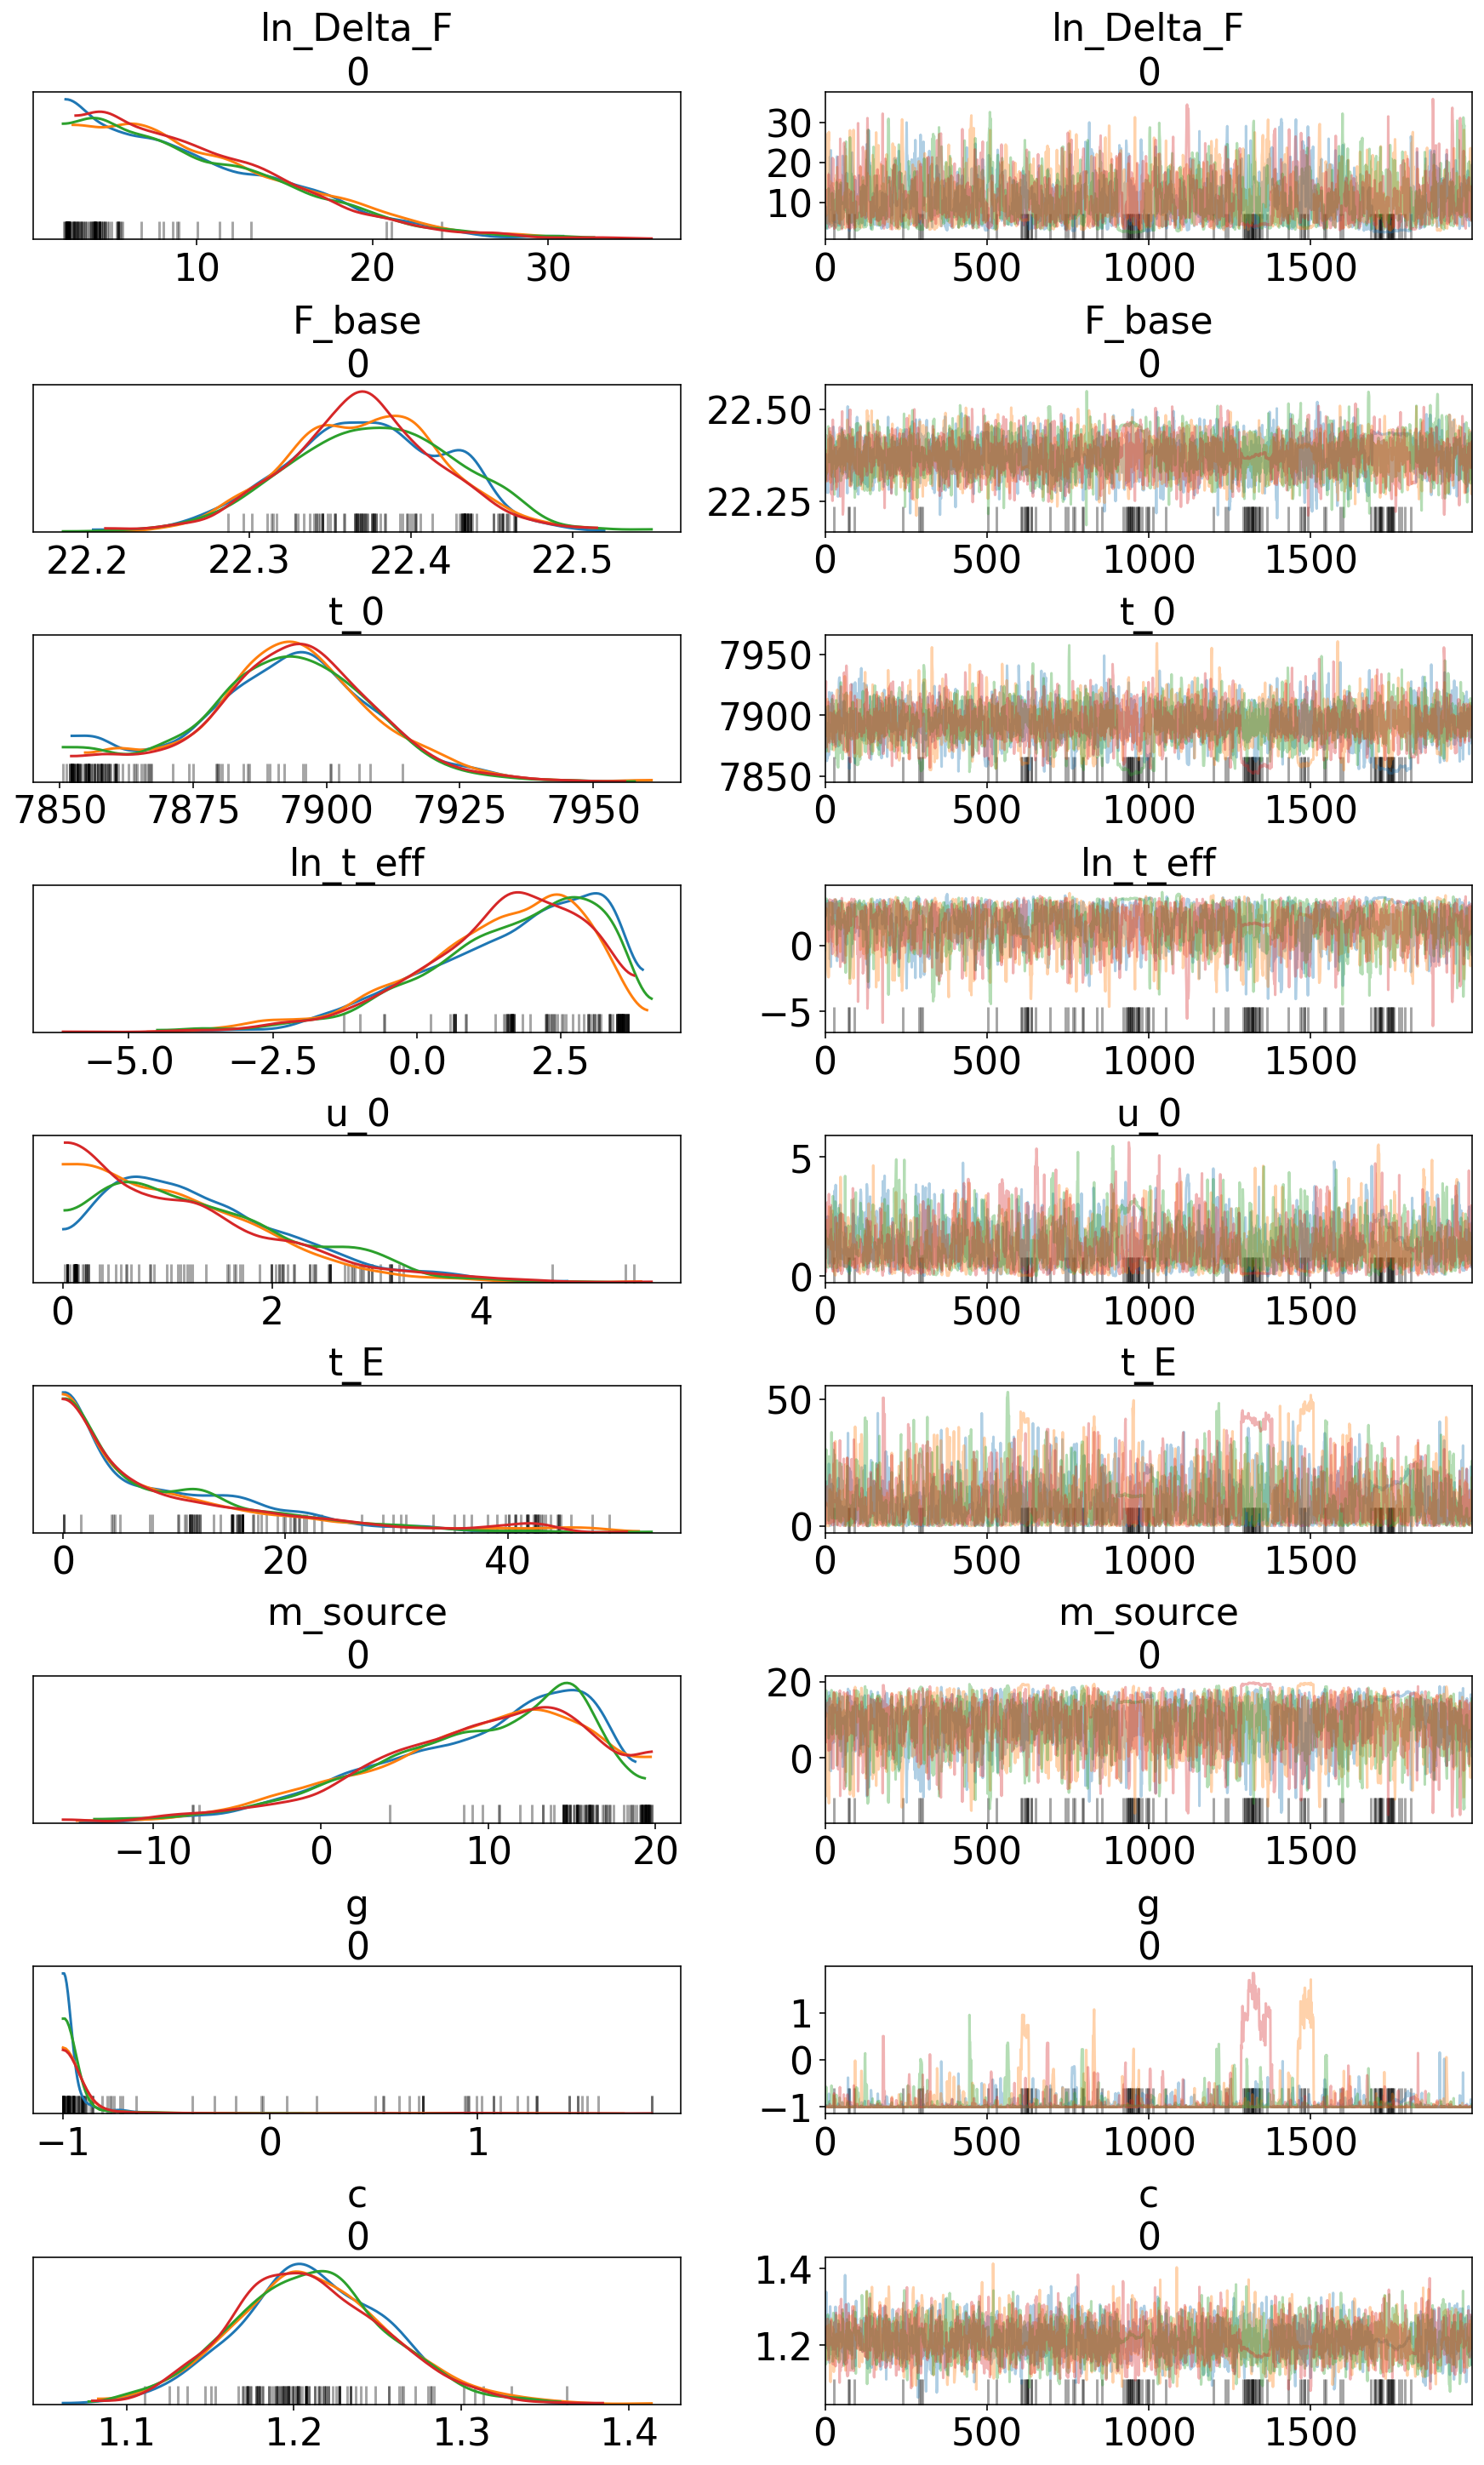

In [21]:
pm.traceplot(trace, figsize=(12, 20));

In [22]:
with pspl_model:
    # Create dense grid
    t_dense = np.tile(np.linspace(pspl_model.t_min, 8000, 2000), (n_bands, 1))
    t_dense_tensor = T.as_tensor_variable(t_dense) 
    
    # Compute the trajectory of the lens
    u_dense = trajectory.compute_trajectory(t_dense_tensor)
    
    # Compute the magnification
    mag_dense = pspl_model.compute_magnification(u_dense, u_0)
    
    # Compute the mean model
    mean_dense = T.exp(ln_Delta_F)*mag_dense + F_base

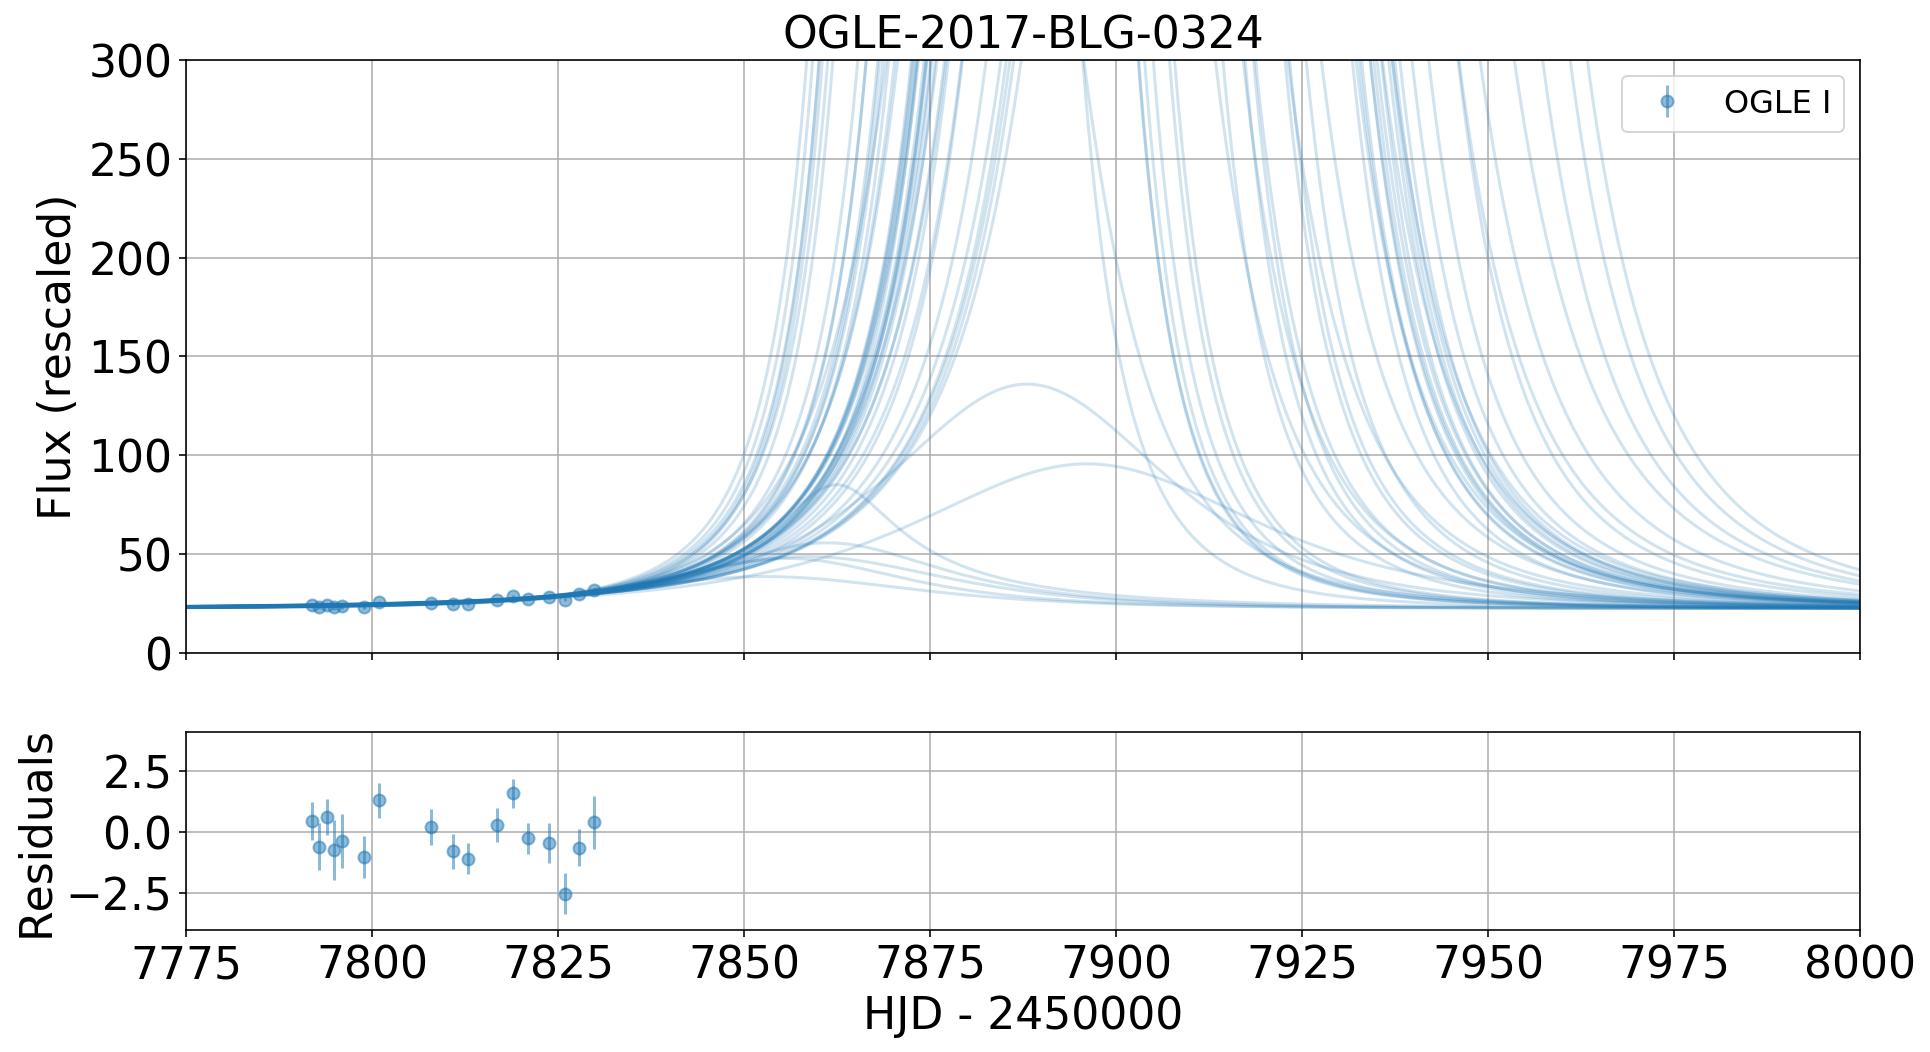

In [23]:
# Plot model
fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios':[3,1]},
            figsize=(15, 8), sharex=True)

ax[0].set_ylim(0, 300)
ax[0].set_xlim(7775, 8000)
ca.plot_model_and_residuals(ax, event_ogle, pspl_model, trace, t_dense_tensor, mean_dense, n_samples=50)

# Fit hierarchical model for multiple light curves

In [28]:
import scipy

def normal_prior(x, params):
    """
    Normal prior.
    """
    mu, sig = params
    
    return scipy.stats.norm.pdf(x, mu, sig)


def log_likelihood_multi(params, samples_w, samples_p_w): 
    """
    Computes the approximate likelihood :math:`p(\theta|\{F_k\})` for
    hyperparameters :math:`\theta` and a population of datasets :math:`\{F_k\}` 
    assuming we have posterior samples for each dataset individually.
    
    Args
    ----
    samples_w : list of ndarays
        Posterior samples for the parameters of interest.
    samples_p_w: list of ndarrays
        Values of the original prior evaluated at posterior samples.
        
    Returns
    -------
    float
        Approximate log-likelihood computed using importance re-sampled prior.
    
    """
    n_events = len(samples_w)
    
    if len(samples_w)!=len(samples_p_w):
        raise ValueError("Dimensions of the two lists of samples don't match")
                
    result = 0
        
    # Iterate over members of the population
    for i in range(n_events):
        n_samples = len(samples_w[i])
                         
        # Compute importance resampling fraction
        frac = normal_prior(samples_w[i], params)/samples_p_w[i]
        result += np.log(np.sum(frac)/float(n_samples)) 
        
    if np.isnan(result):
        return -np.inf
    
    return result 

def log_prior_multi(params):
    """
    Log of hyperprior for population level parameters.
    """    
    mu, sig = params
    
    # Mu
    ll = np.log(scipy.stats.norm.pdf(mu, 5, 10.))
    
    # Sigma
    ll += np.log(scipy.stats.norm.pdf(sig, 5., 10.))
        
    return ll


def log_posterior_multi(params, samples_w, samples_p_w):
    """
    Compute log-posterior over hyperparameters.
    """
    lp = log_prior_multi(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_multi(params, samples_w, samples_p_w)

In [29]:
%timeit log_posterior_multi([2., 5.], samples[::3], np.exp(logp_samples[::3]))

134 ms ± 900 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [30]:
ndim, nwalkers = 2, 20

initial = [[2., 5.] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

from multiprocessing import Pool

os.environ["OMP_NUM_THREADS"] = "1"

nsteps = 800
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_multi,
           args=(samples[::3], np.exp(logp_samples[::3])), pool=pool)
    sampler.run_mcmc(initial, nsteps, progress=True)

100%|██████████| 800/800 [10:40<00:00,  1.26it/s]


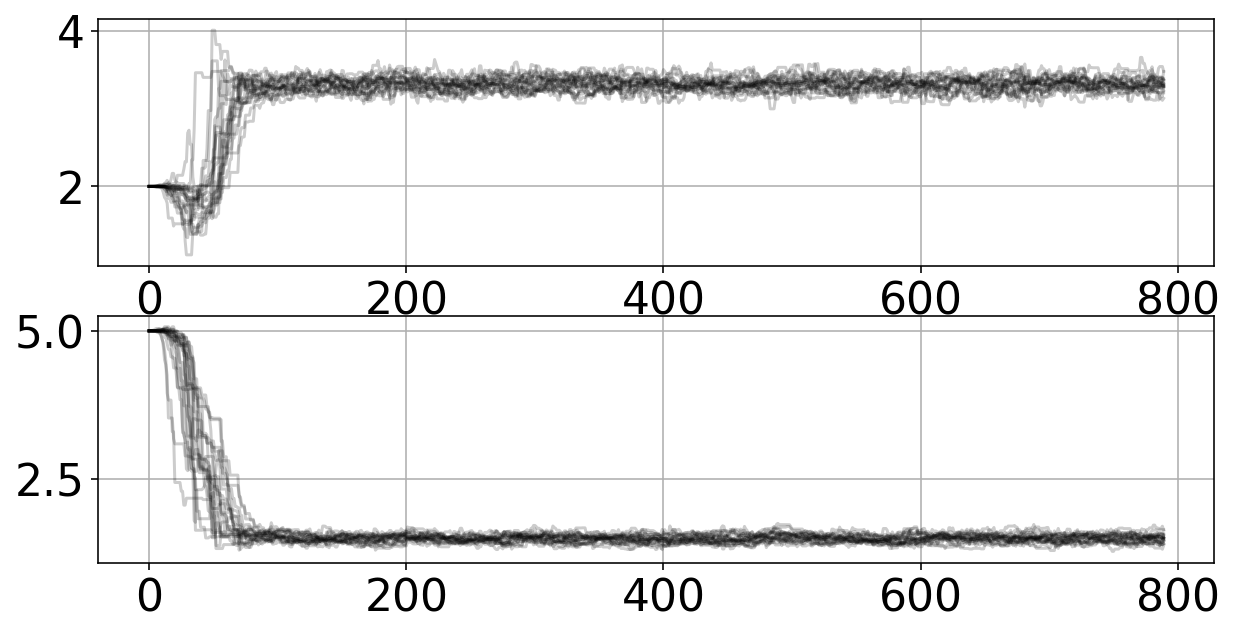

In [31]:
# Plot traceplots
fig, ax = plt.subplots(ndim, 1, figsize=(10, 5))

for i in range(ndim):
    mask = sampler.acceptance_fraction > .0
    ax[i].plot(sampler.chain[mask, 10:, i].T, 'k-', alpha=0.2);
    ax[i].grid()

Text(0.5, 1.0, 'Population level distribution for $\\ln\\,\\Delta F$ ')

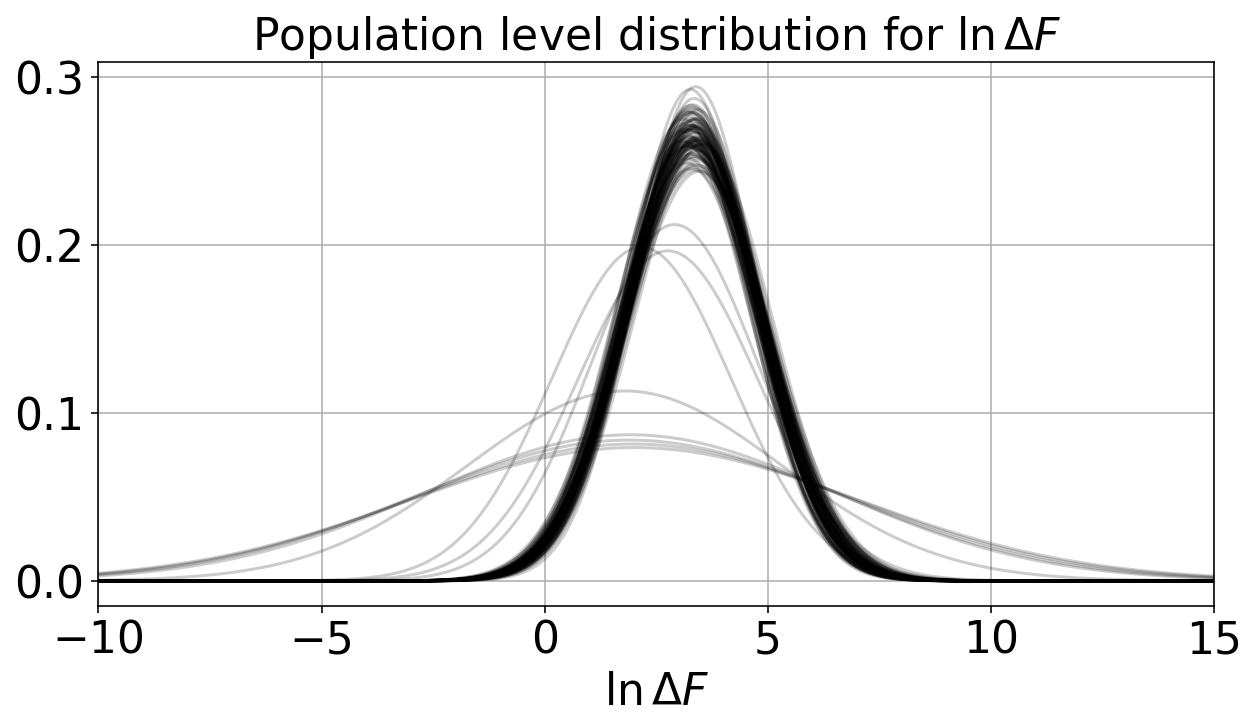

In [41]:
fig, ax = plt.subplots(figsize=(10, 5))

x = np.linspace(-10, 15., 2000)
samples_hyper = sampler.flatchain[400:, :2]

for mu, sig in samples_hyper[np.random.randint(len(samples_hyper), size=100)]:
    ax.plot(x, normal_prior(x, (mu, sig)), color='black', alpha=0.2)

ax.grid()
ax.set_xlabel(r'$\ln\,\Delta F$')
ax.set_xlim(-10, 15)
ax.set_title('Population level distribution for $\ln\,\Delta F$ ')

# Fit hierarchical predictive model

In [42]:
# Likelihood for the individual light curve shown above
import theano
with pspl_model:              
    # Builds a theano function which takes the model parameters
    # and returns the log likelihood
    f = theano.function(pspl_model.vars, [pspl_model.potentials[0]])

    def log_likelihood_single(params):
        dct = pspl_model.bijection.rmap(params[::-1])
        args = (dct[k.name] for k in pspl_model.vars)
        results = f(*args)
        return tuple(results)[0]

In [43]:
def log_prior_predictive(params):
    """
    Prior for 
    """
    mu, sig, ln_Delta_F, F_base, t_0,\
        u_0_lowerbound, ln_t_eff, c_lowerbound = params
    
    # Mu
    ll = np.log(scipy.stats.norm.pdf(mu, 3, 5.))
    
    # Sigma
    ll += np.log(scipy.stats.norm.pdf(sig, 5., 5.))
    
    # ln_Delta_F
    ll += np.log(scipy.stats.norm.pdf(ln_Delta_F, loc=mu, scale=sig))

    # F_base__
    ll += np.log(scipy.stats.norm.pdf(F_base, loc=0., scale=1e3))

    # t_0
    t_mid = (pspl_model.t_max - pspl_model.t_min)/2.
    t_range = pspl_model.t_max - pspl_model.t_min
    ll += np.log(scipy.stats.norm.pdf(t_0, loc=t_mid, scale=2*t_range))

    # u_0_lowerbound__
    ll += np.log(scipy.stats.norm.pdf(u_0_lowerbound, loc=-1., scale=3.))

    # ln_t_eff
    ll += np.log(scipy.stats.norm.pdf(ln_t_eff, loc=3., scale=5.))

    # c_lowerbound
    ll += np.log(scipy.stats.norm.pdf(c_lowerbound, loc=-1, scale=2.))
            
    return ll

def log_likelihood_predictive(params, samples_w, samples_p_w): 
    """
    Computes the approximate likelihood :math:`p(\theta|\{F_k\})` for
    hyperparameters :math:`\theta` and a population of datasets :math:`\{F_k\}` 
    assuming we have posterior samples for each dataset individually.
    
    Args
    ----
    samples_w : list of ndarays
        Posterior samples for the parameters of interest.
    samples_p_w: list of ndarrays
        Values of the original prior evaluated at posterior samples.
        
    Returns
    -------
    float
        Approximate log-likelihood computed using importance re-sampled prior.
    
    """
    n_events = len(samples_w)
    
    if len(samples_w)!=len(samples_p_w):
        raise ValueError("Dimensions of the two lists of samples don't match")
                
    result = 0
        
    # Iterate over members of the population
    for i in range(n_events):
        n_samples = len(samples_w[i])
                         
        # Compute importance resampling fraction
        frac = normal_prior(samples_w[i], params)/samples_p_w[i]
        result += np.log(np.sum(frac)/float(n_samples)) 
        
    if np.isnan(result):
        return -np.inf
    
    return result 


def log_posterior_predictive(params, samples_w, samples_p_w):
    """
    Compute log-posterior over hyperparameters.
    """
    lp = log_prior_predictive(params)
    if not np.isfinite(lp):
        return -np.inf
    l_tot = lp + log_likelihood_multi(params[:2], samples_w, samples_p_w) + log_likelihood_single(params[2:])
    
    if np.isnan(l_tot):
        return -np.inf
    
    return l_tot

In [44]:
%timeit log_posterior_predictive([2., 2., 2., 0.1, 0.5, 0.1, 20., 1.2], samples[::3], np.exp(logp_samples[::3]))

130 ms ± 1.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [45]:
ndim, nwalkers = 8, 50

init_F_base = ca.utils.estimate_baseline_flux(event_ogle)[0]
init_t_0 = ca.utils.estimate_t0(event_ogle)
initial = [[2., 2., init_ln_Delta_F[0], init_F_base, init_t_0 , 0.1, 3., 1.2] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

nsteps = 3000
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_predictive,
           args=(samples[::3], np.exp(logp_samples[::3])), pool=pool)
    sampler.run_mcmc(initial, nsteps, progress=True)

100%|██████████| 3000/3000 [1:23:58<00:00,  1.76s/it]


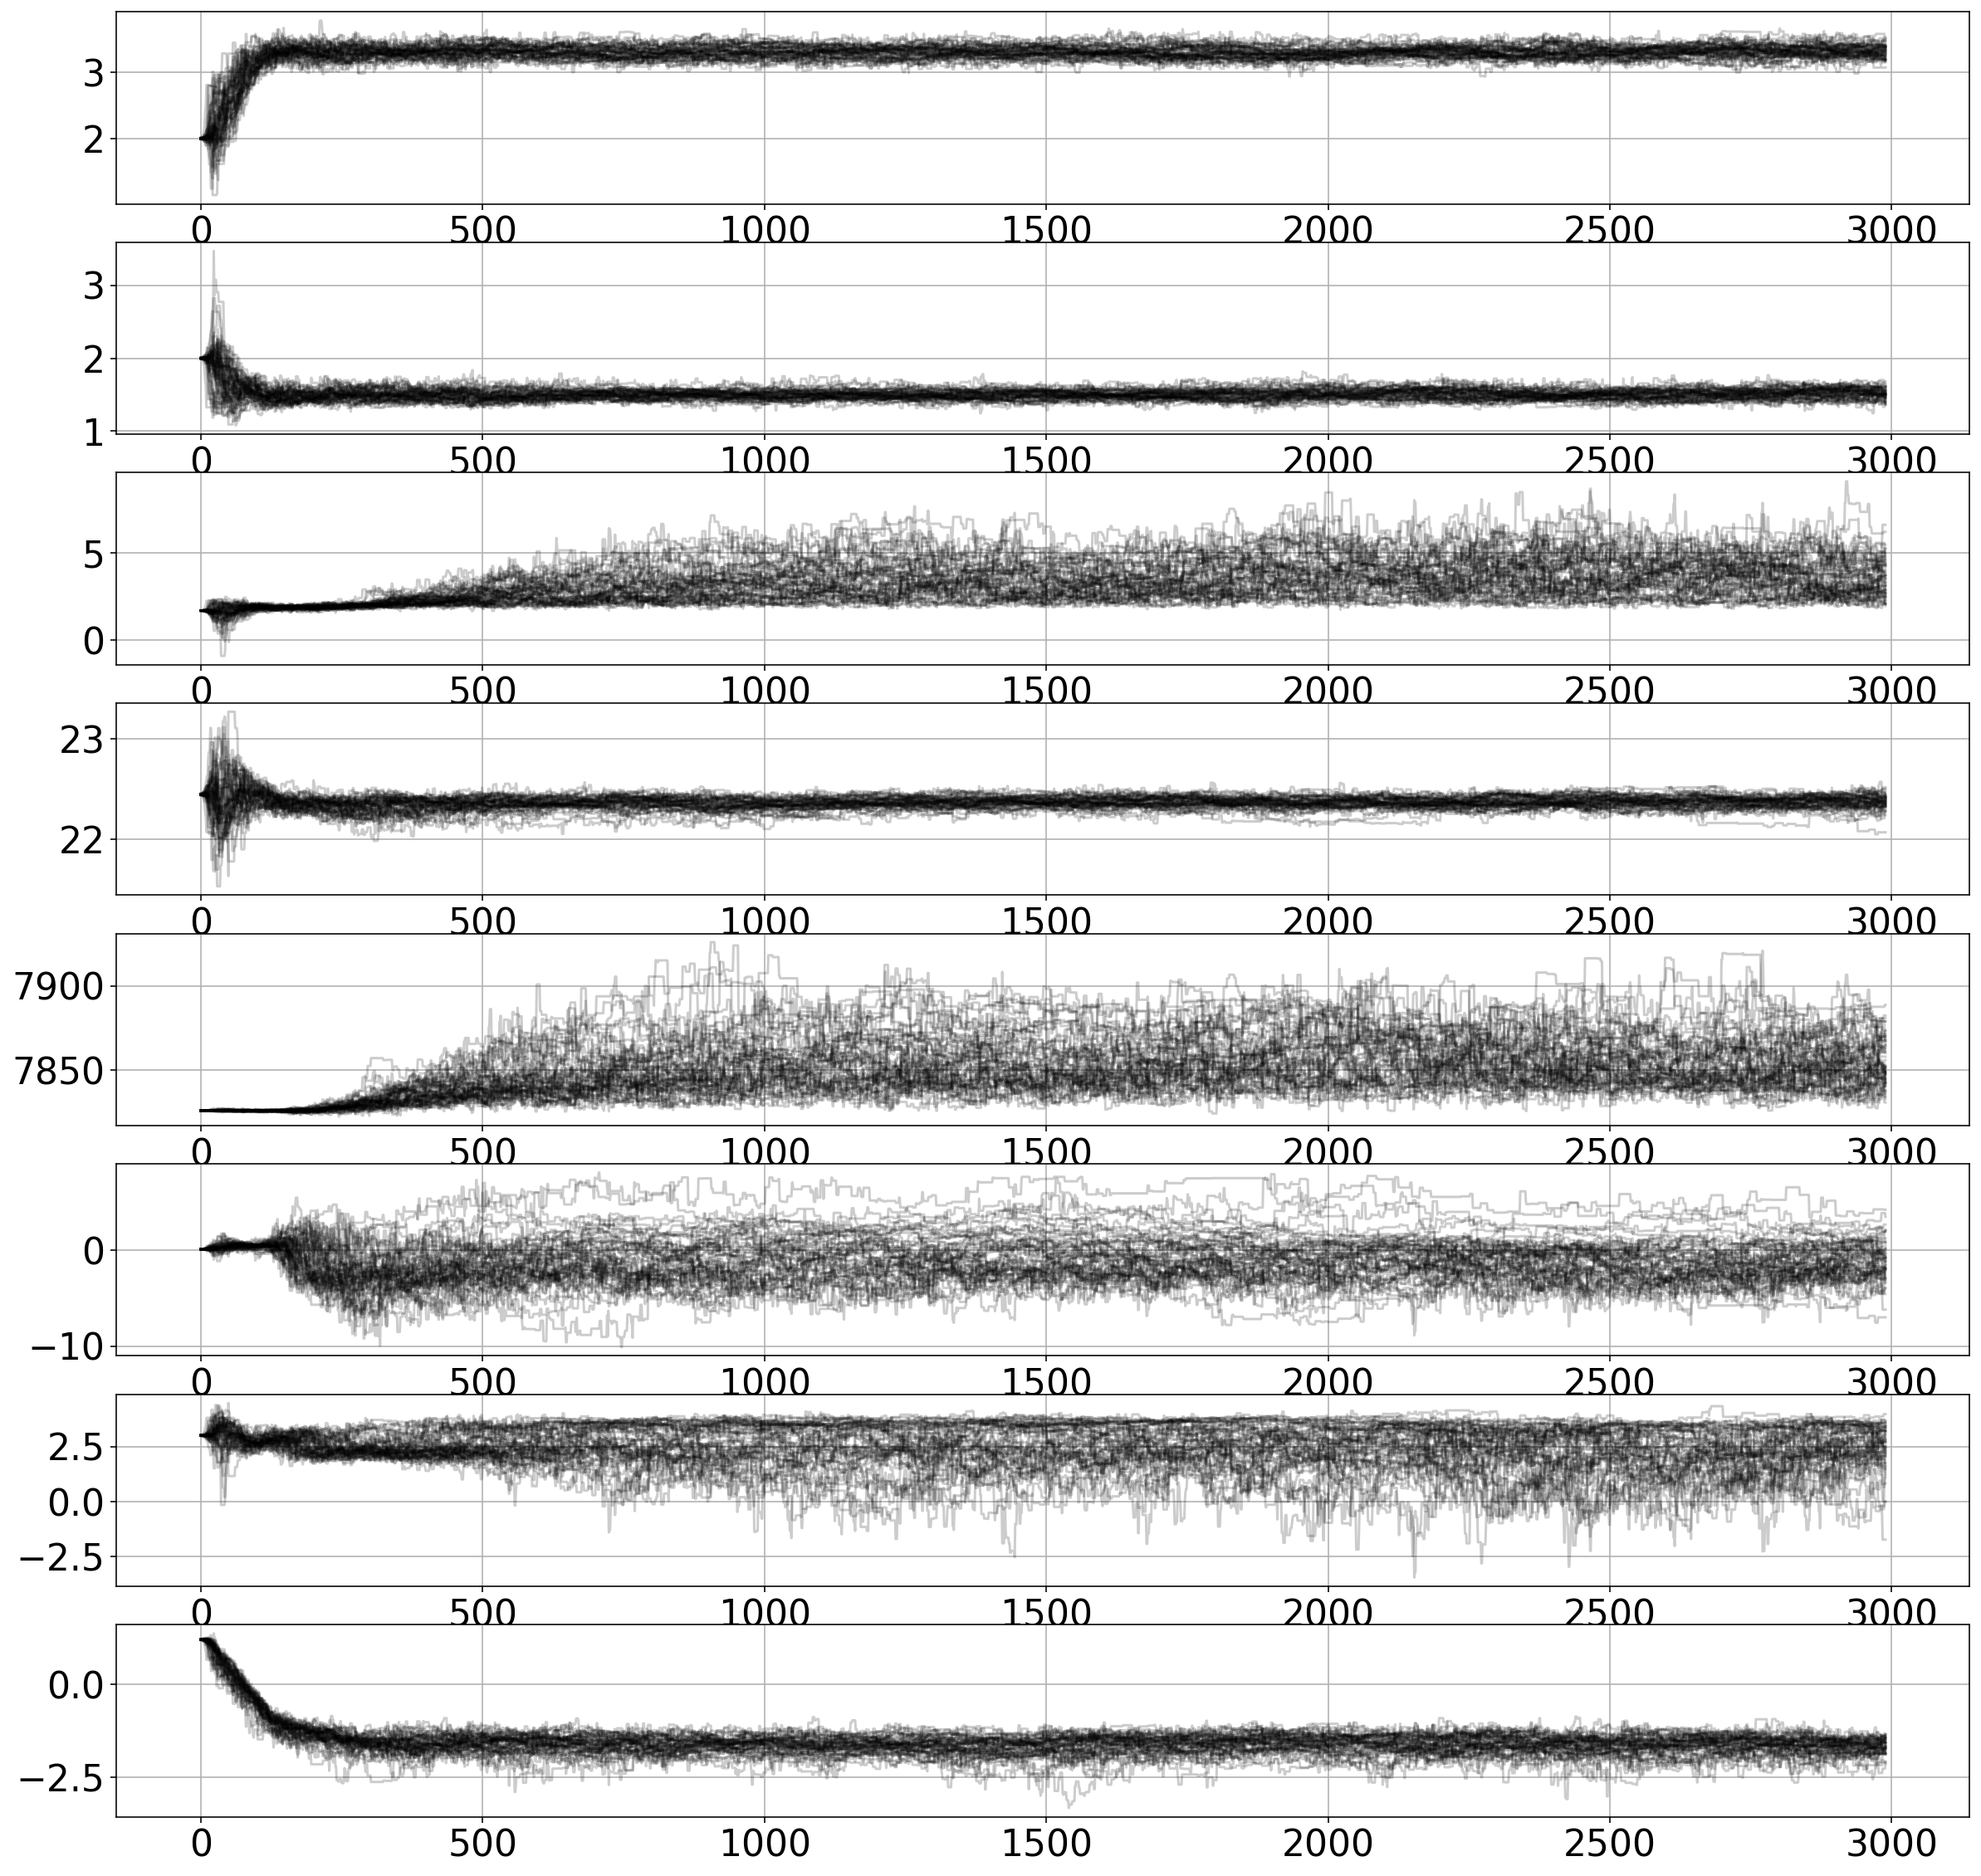

In [46]:
# Plot traceplots
fig, ax = plt.subplots(ndim, 1, figsize=(20, 20))

for i in range(ndim):
    mask = sampler.acceptance_fraction > .05
    ax[i].plot(sampler.chain[mask, 10:, i].T, 'k-', alpha=0.2);
    ax[i].grid()

In [47]:
samples_predictive = sampler.get_chain(discard=300, flat=True)

Text(0.5, 1.0, 'Population level distribution for $\\ln\\,\\Delta F$ ')

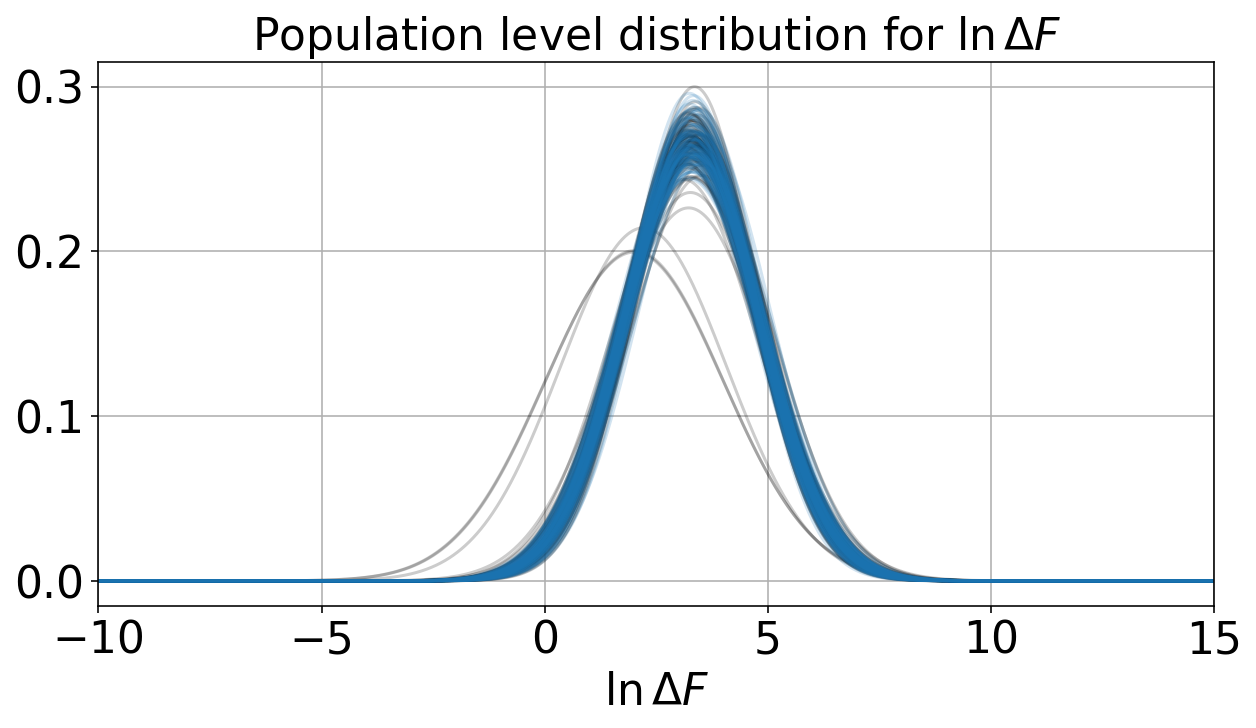

In [51]:
fig, ax = plt.subplots(figsize=(10, 5))

x = np.linspace(-10, 15., 2000)
samples_hyper = sampler.flatchain[400:, :2]

for mu, sig in samples_hyper[np.random.randint(len(samples_hyper), size=100)]:
    ax.plot(x, normal_prior(x, (mu, sig)), color='black', alpha=0.2)

for mu, sig in samples_predictive[:, :2][np.random.randint(len(samples_predictive[:, :2]), size=100)]:
    ax.plot(x, normal_prior(x, (mu, sig)), color='C0', alpha=0.2)

ax.grid()
ax.set_xlabel(r'$\ln\,\Delta F$')
ax.set_xlim(-10, 15)
ax.set_title('Population level distribution for $\ln\,\Delta F$ ')

Text(0.5, 1.0, 'Posterior over the $\\ln\\,\\Delta F$ parameter')

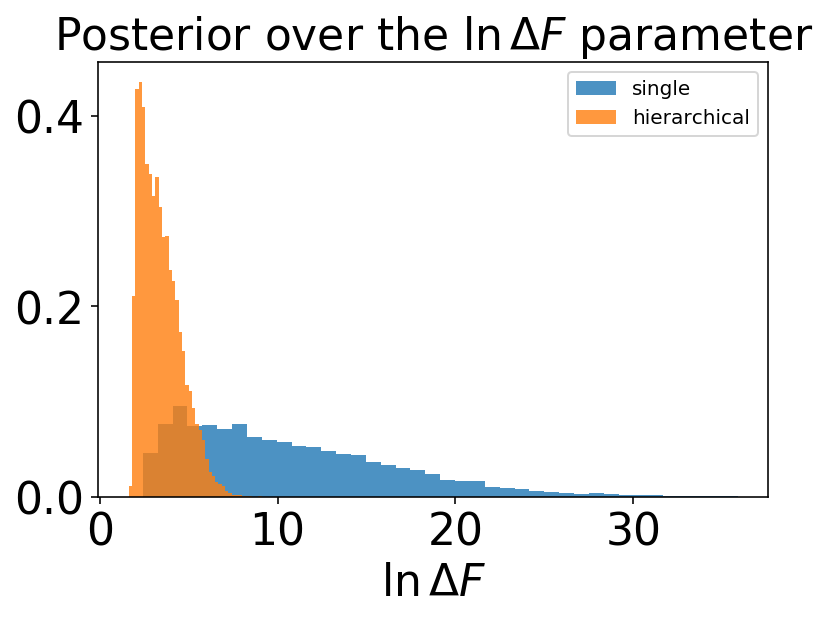

In [52]:
fig, ax = plt.subplots()
ax.hist(trace['ln_Delta_F'], bins=40, density=True, alpha = 0.8, color='C0', label='single');
ax.hist(samples_predictive[:, 2], bins=40, density=True, alpha=0.8, color='C1', label='hierarchical');
ax.legend()
ax.set_xlabel(r'$\ln\,\Delta F$')
ax.set_title('Posterior over the $\ln\,\Delta F$ parameter')

In [55]:
def plot_model(ax, data, pm_model, trace, t_grid, prediction, color='C0'):   
    n_samples = 500
    
    # Check if trace is a PyMC3 object or a raw numpy array, extract samples
    if isinstance(trace, np.ndarray):
        trace = trace[np.random.randint(len(trace), size=n_samples)]
        # Map parameters to a dictionary which can be evaluated in model context
        samples = [pm_model.bijection.rmap(params[::-1]) for params in trace]
    else: 
        samples = xo.get_samples_from_trace(trace, size=n_samples)

    # Load data
    if pm_model.standardized_data==True:
        tables = data.get_standardized_data()
    else:
        tables = data.get_standardized_data(rescale=False)

    # Evaluate model for each sample on a fine grid
    n_pts_dense = T.shape(t_grid)[1].eval()
    n_bands = len(data.light_curves)

    prediction_eval = np.zeros((n_samples, n_bands, n_pts_dense))

    # Evaluate predictions in model context
    with pm_model:
        for i, sample in enumerate(samples):
            prediction_eval[i] = xo.eval_in_model(prediction, sample) 
    
    for i in range(n_bands):
        q = np.percentile(prediction_eval[:, i, :], [16, 84], axis=0)
        ax.fill_between(t_grid[i].eval(), q[0], q[1], color=color, alpha=0.8, lw=0)

    # Plot data
    data.plot(ax)
    ax.set_xlabel(None)
    ax.set_xlabel('HJD - 2450000')                

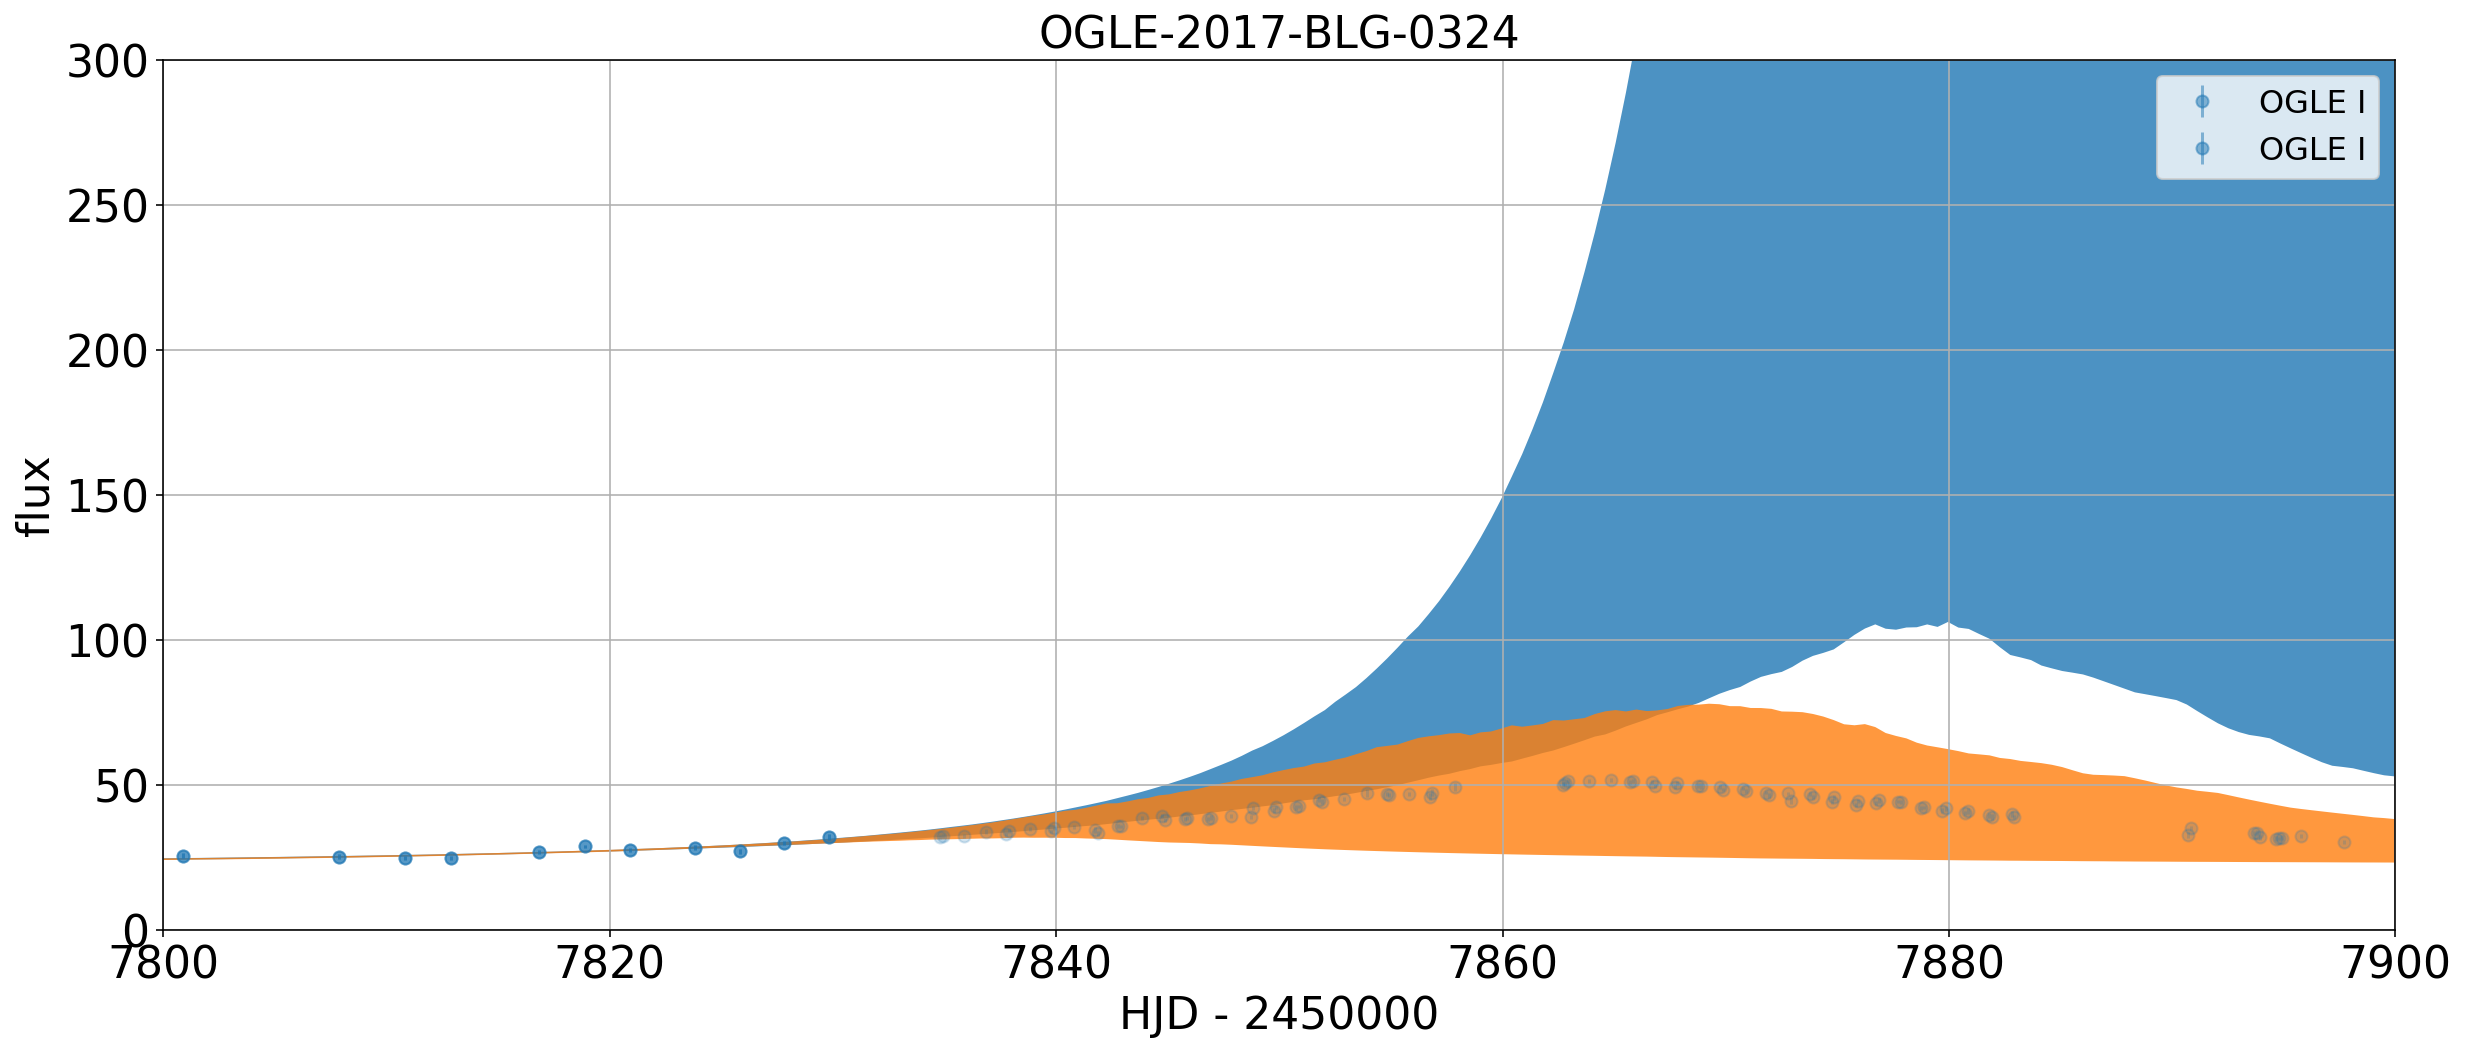

In [56]:
# Plot model
fig, ax = plt.subplots(figsize=(20, 8))

ax.set_ylim(0, 300)
ax.set_xlim(7800, 7900)
plot_model(ax, event_ogle, pspl_model, 
                            trace, t_dense_tensor, mean_dense, color='C0')
plot_model(ax, event_ogle, pspl_model, 
                            samples_predictive, t_dense_tensor, mean_dense,  color='C1')